# Transfer Learning with TensorFlow Part 3: Scaling Up (Food Vision)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 classes of food).

Our goal is to beat the original Food101 paper with 10% of the training data (leveraging the power of deep learning)

Our baseline to beat is 50.76% accuracy across 101 classes

## Creating helper functions

In previous notebooks, we've created a series of helper function to do different tasks, let's download and import them

In [1]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

##  101 Food Classes: Working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the `image_data_modification` notebook

In [13]:
# Unzip the data
unzip_data("101_food_classes_10_percent.zip")

In [3]:
# Setup directories
train_dir="101_food_classes_10_percent/train/"
test_dir="101_food_classes_10_percent/test/"

In [14]:
# How many images/class in our dataset
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\gnocchi'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\donuts'.
There are 0 directories and 250 images in '101_food_class

In [15]:
# Setup our data loaders 
import tensorflow as tf
IMG_SIZE=(224,224)
BATCH_SIZE=32

train_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              image_size=IMG_SIZE,
                                                                              batch_size=BATCH_SIZE,
                                                                              label_mode="categorical")

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              image_size=IMG_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              label_mode="categorical",
                                                              shuffle=False) # don't shuffle test data for prediction analysis                                                                                                                                                                                                                                                         

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a `ModelCheckpoint` callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)


In [16]:
# Create checkpoint callback
checkpoint_path="101_food_classes_10_percent_data_model_checkpoint"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_weights_only=True,
                                                       monitor="val_accuracy",
                                                       save_best_only=True)

In [17]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation=tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
],name="data_augmentation")

In [18]:
# Build a headless model (no top layers) Functional EfficientNetB0 model

# Input shape of the data
input_shape=(224,224,3)

# Create a frozen base model
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create layers
inputs=layers.Input(shape=input_shape,name="input_layer")
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs=layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)

# Construct model
model=tf.keras.Model(inputs,outputs)        

In [8]:
# Get a summary of the model we created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [19]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model 
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)), # validate on only 15% of the data
                                           callbacks=[checkpoint_callback])


Epoch 1/5
237/237 [==============================] - 83s 331ms/step - loss: 3.2084 - accuracy: 0.3109 - val_loss: 2.4031 - val_accuracy: 0.4616
Epoch 2/5
237/237 [==============================] - 71s 299ms/step - loss: 1.9596 - accuracy: 0.5585 - val_loss: 1.9615 - val_accuracy: 0.5177
Epoch 3/5
237/237 [==============================] - 70s 297ms/step - loss: 1.5705 - accuracy: 0.6279 - val_loss: 1.8206 - val_accuracy: 0.5336
Epoch 4/5
237/237 [==============================] - 67s 282ms/step - loss: 1.3532 - accuracy: 0.6807 - val_loss: 1.7721 - val_accuracy: 0.5381
Epoch 5/5
237/237 [==============================] - 65s 273ms/step - loss: 1.1756 - accuracy: 0.7233 - val_loss: 1.7334 - val_accuracy: 0.5474


In [20]:
# Evaluate on the whole test dataset
feature_extraction_results=model.evaluate(test_data)

790/790 [==============================] - 95s 120ms/step - loss: 1.4961 - accuracy: 0.6041


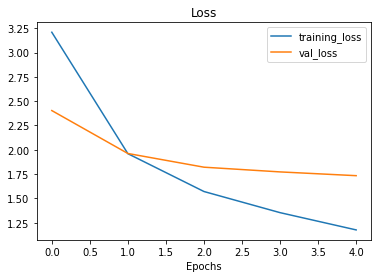

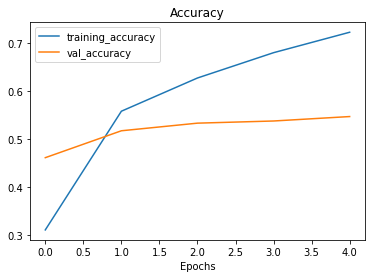

In [21]:
# Let's look at the loss curves
plot_loss_curves(history_all_classes_10_percent)

**Note**: It appears that our model is overfitting (performing too well on the training data and not generalizing to unseen data)

## Fine-tuning

In [22]:
# Unfreeze all of the layers in the base model
base_model.trainable=True

# Refreeze every layer but the last 5
for layer in base_model.layers[:-5]:
    layer.trainable=False

In [23]:
# Recompile the model with lower learning_rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [24]:
# What layers in the model are trainable
for layer in model.layers:
    print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [25]:
# Check which layers are trainabale in our base model
for layer_number,layer in enumerate(base_model.layers):
    print(layer_number,layer.name,layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 tf.math.truediv_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [26]:
# Fine tune for another 5 epochs
# model has already done 5 epochs, total number of epochs we're after (5+5 = 10)
fine_tune_epochs = 10

# Refit the model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1],
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)))


Epoch 5/10
237/237 [==============================] - 75s 282ms/step - loss: 0.9314 - accuracy: 0.7599 - val_loss: 1.7025 - val_accuracy: 0.5551
Epoch 6/10
237/237 [==============================] - 64s 269ms/step - loss: 0.8061 - accuracy: 0.7898 - val_loss: 1.6827 - val_accuracy: 0.5617
Epoch 7/10
237/237 [==============================] - 61s 257ms/step - loss: 0.7186 - accuracy: 0.8098 - val_loss: 1.7019 - val_accuracy: 0.5546
Epoch 8/10
237/237 [==============================] - 60s 255ms/step - loss: 0.6566 - accuracy: 0.8290 - val_loss: 1.6803 - val_accuracy: 0.5630
Epoch 9/10
237/237 [==============================] - 59s 249ms/step - loss: 0.5971 - accuracy: 0.8466 - val_loss: 1.7332 - val_accuracy: 0.5575
Epoch 10/10
237/237 [==============================] - 60s 255ms/step - loss: 0.5277 - accuracy: 0.8673 - val_loss: 1.7656 - val_accuracy: 0.5495


In [27]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results=model.evaluate(test_data)

790/790 [==============================] - 94s 119ms/step - loss: 1.4819 - accuracy: 0.6141


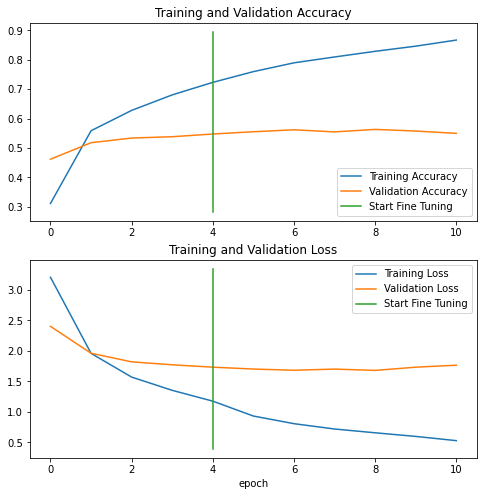

In [28]:
compare_historys(history_all_classes_10_percent,history_all_classes_10_percent_fine_tune)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere

In [ ]:
# Save our fine-tuned model
model.save("G:/UMass/Courses/Year_4 (2022)/TensorFlowDeveloperLocal/TensorFlow-Developer-Course/101_food_classes_10_percent_saved_big_dog_model")

In [11]:
# Load an evaluated model
loaded_model=tf.keras.models.load_model("G:/UMass/Courses/Year_4 (2022)/TensorFlowDeveloperLocal/TensorFlow-Developer-Course/101_food_classes_10_percent_saved_big_dog_model")

In [29]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results=loaded_model.evaluate(test_data)

790/790 [==============================] - 96s 122ms/step - loss: 1.4292 - accuracy: 0.6255


In [30]:
# The results from oour loaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.4819090366363525, 0.6140990257263184]

## Evaluating the performance of the big model across all different classes

Let's make some predictions, visualize them, and then later find out which predictions were the "most" wrong

In [ ]:
# Unzip the data
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load in saved model
model=tf.keras.models.load_model("G:/UMass/Courses/Year_4 (2022)/TensorFlowDeveloperLocal/TensorFlow-Developer-Course/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate the loaded model
results_downloaded_model=model.evaluate(test_data)

## Making predictions with our trained model

In [31]:
# Making predictions with model
preds_probs = model.predict(test_data,verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 95s 119ms/step


In [34]:
# How many predictions are there? 
len(preds_probs)

25250

In [35]:
# What is the shape of our predictions?
preds_probs.shape

(25250, 101)

In [36]:
# Let's see what the first 10 predicitions look like
preds_probs[:10]

array([[2.34656900e-01, 1.00347526e-04, 1.10296592e-01, ...,
        5.97513099e-06, 5.94813423e-03, 2.34529953e-02],
       [8.09014499e-01, 9.21167764e-09, 2.45536095e-03, ...,
        2.77791102e-03, 5.58304748e-07, 1.33255317e-05],
       [6.80060983e-01, 4.26416099e-03, 2.12936774e-02, ...,
        9.69136527e-05, 3.59654252e-04, 2.26011313e-03],
       ...,
       [2.97113657e-01, 4.23219007e-07, 2.07166839e-03, ...,
        1.69535540e-02, 2.32930601e-04, 1.35088892e-04],
       [1.93208426e-01, 1.11964226e-04, 2.01649278e-01, ...,
        8.54561586e-05, 2.77251063e-04, 6.98129661e-05],
       [5.45732379e-01, 1.83930382e-07, 2.66937399e-03, ...,
        1.24333368e-03, 7.82883319e-07, 1.43779197e-03]], dtype=float32)

In [38]:
# What does the first predicition probability look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([2.34656900e-01, 1.00347526e-04, 1.10296592e-01, 1.81648801e-07,
        3.25472524e-06, 5.22007497e-07, 4.16706935e-05, 8.40337748e-07,
        2.46958155e-02, 1.91444764e-04, 3.98200382e-06, 1.14898958e-05,
        9.56900767e-04, 8.67690702e-08, 1.64671359e-03, 2.30133138e-03,
        8.86953276e-05, 6.41099396e-05, 1.34348357e-02, 2.48282686e-06,
        2.80452217e-03, 1.10431292e-05, 1.55960704e-04, 1.21637830e-04,
        3.08145466e-03, 2.23126728e-03, 1.54701341e-03, 9.03167347e-06,
        7.27906525e-02, 6.21996471e-04, 1.28748422e-06, 3.05055903e-04,
        5.02204406e-04, 5.47575894e-07, 2.46511679e-03, 1.49275877e-06,
        2.55721767e-04, 1.16930390e-03, 1.64365411e-01, 9.10932285e-05,
        4.18998476e-04, 5.37648739e-04, 2.39634392e-04, 8.47750016e-06,
        7.52538617e-05, 4.91331411e-05, 6.38585712e-04, 3.73724652e-05,
        6.33700165e-06, 4.34821099e-02, 1.08769315e-03, 3.90477071e-05,
        1.06578492e-01, 2.80250073e-03, 5.13093328e-05, 2.236294

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes for each sampe passed to the predict method

In [41]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicited probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [2.34656900e-01 1.00347526e-04 1.10296592e-01 1.81648801e-07
 3.25472524e-06 5.22007497e-07 4.16706935e-05 8.40337748e-07
 2.46958155e-02 1.91444764e-04 3.98200382e-06 1.14898958e-05
 9.56900767e-04 8.67690702e-08 1.64671359e-03 2.30133138e-03
 8.86953276e-05 6.41099396e-05 1.34348357e-02 2.48282686e-06
 2.80452217e-03 1.10431292e-05 1.55960704e-04 1.21637830e-04
 3.08145466e-03 2.23126728e-03 1.54701341e-03 9.03167347e-06
 7.27906525e-02 6.21996471e-04 1.28748422e-06 3.05055903e-04
 5.02204406e-04 5.47575894e-07 2.46511679e-03 1.49275877e-06
 2.55721767e-04 1.16930390e-03 1.64365411e-01 9.10932285e-05
 4.18998476e-04 5.37648739e-04 2.39634392e-04 8.47750016e-06
 7.52538617e-05 4.91331411e-05 6.38585712e-04 3.73724652e-05
 6.33700165e-06 4.34821099e-02 1.08769315e-03 3.90477071e-05
 1.06578492e-01 2.80250073e-03 5.13093328e-05 2.23629479e-03
 6.19656406e-03 1.49361964e-03 8.43094382e-

In [44]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look? 
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29, 46,  9,  0], dtype=int64)

In [45]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we have got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels

In [46]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [47]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []

for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, ... , 0, 0], we want the index of the highest value where the 1 occurs

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [48]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predicitons array is in the same order as the test labels array is to find the accuracy score.

In [52]:
# Let's try scikit-learns accuracy score functions and see what it comes up with
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

sklearn_accuracy

0.6140990099009901

## Let's get visual: making a confusion matrix

In [55]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

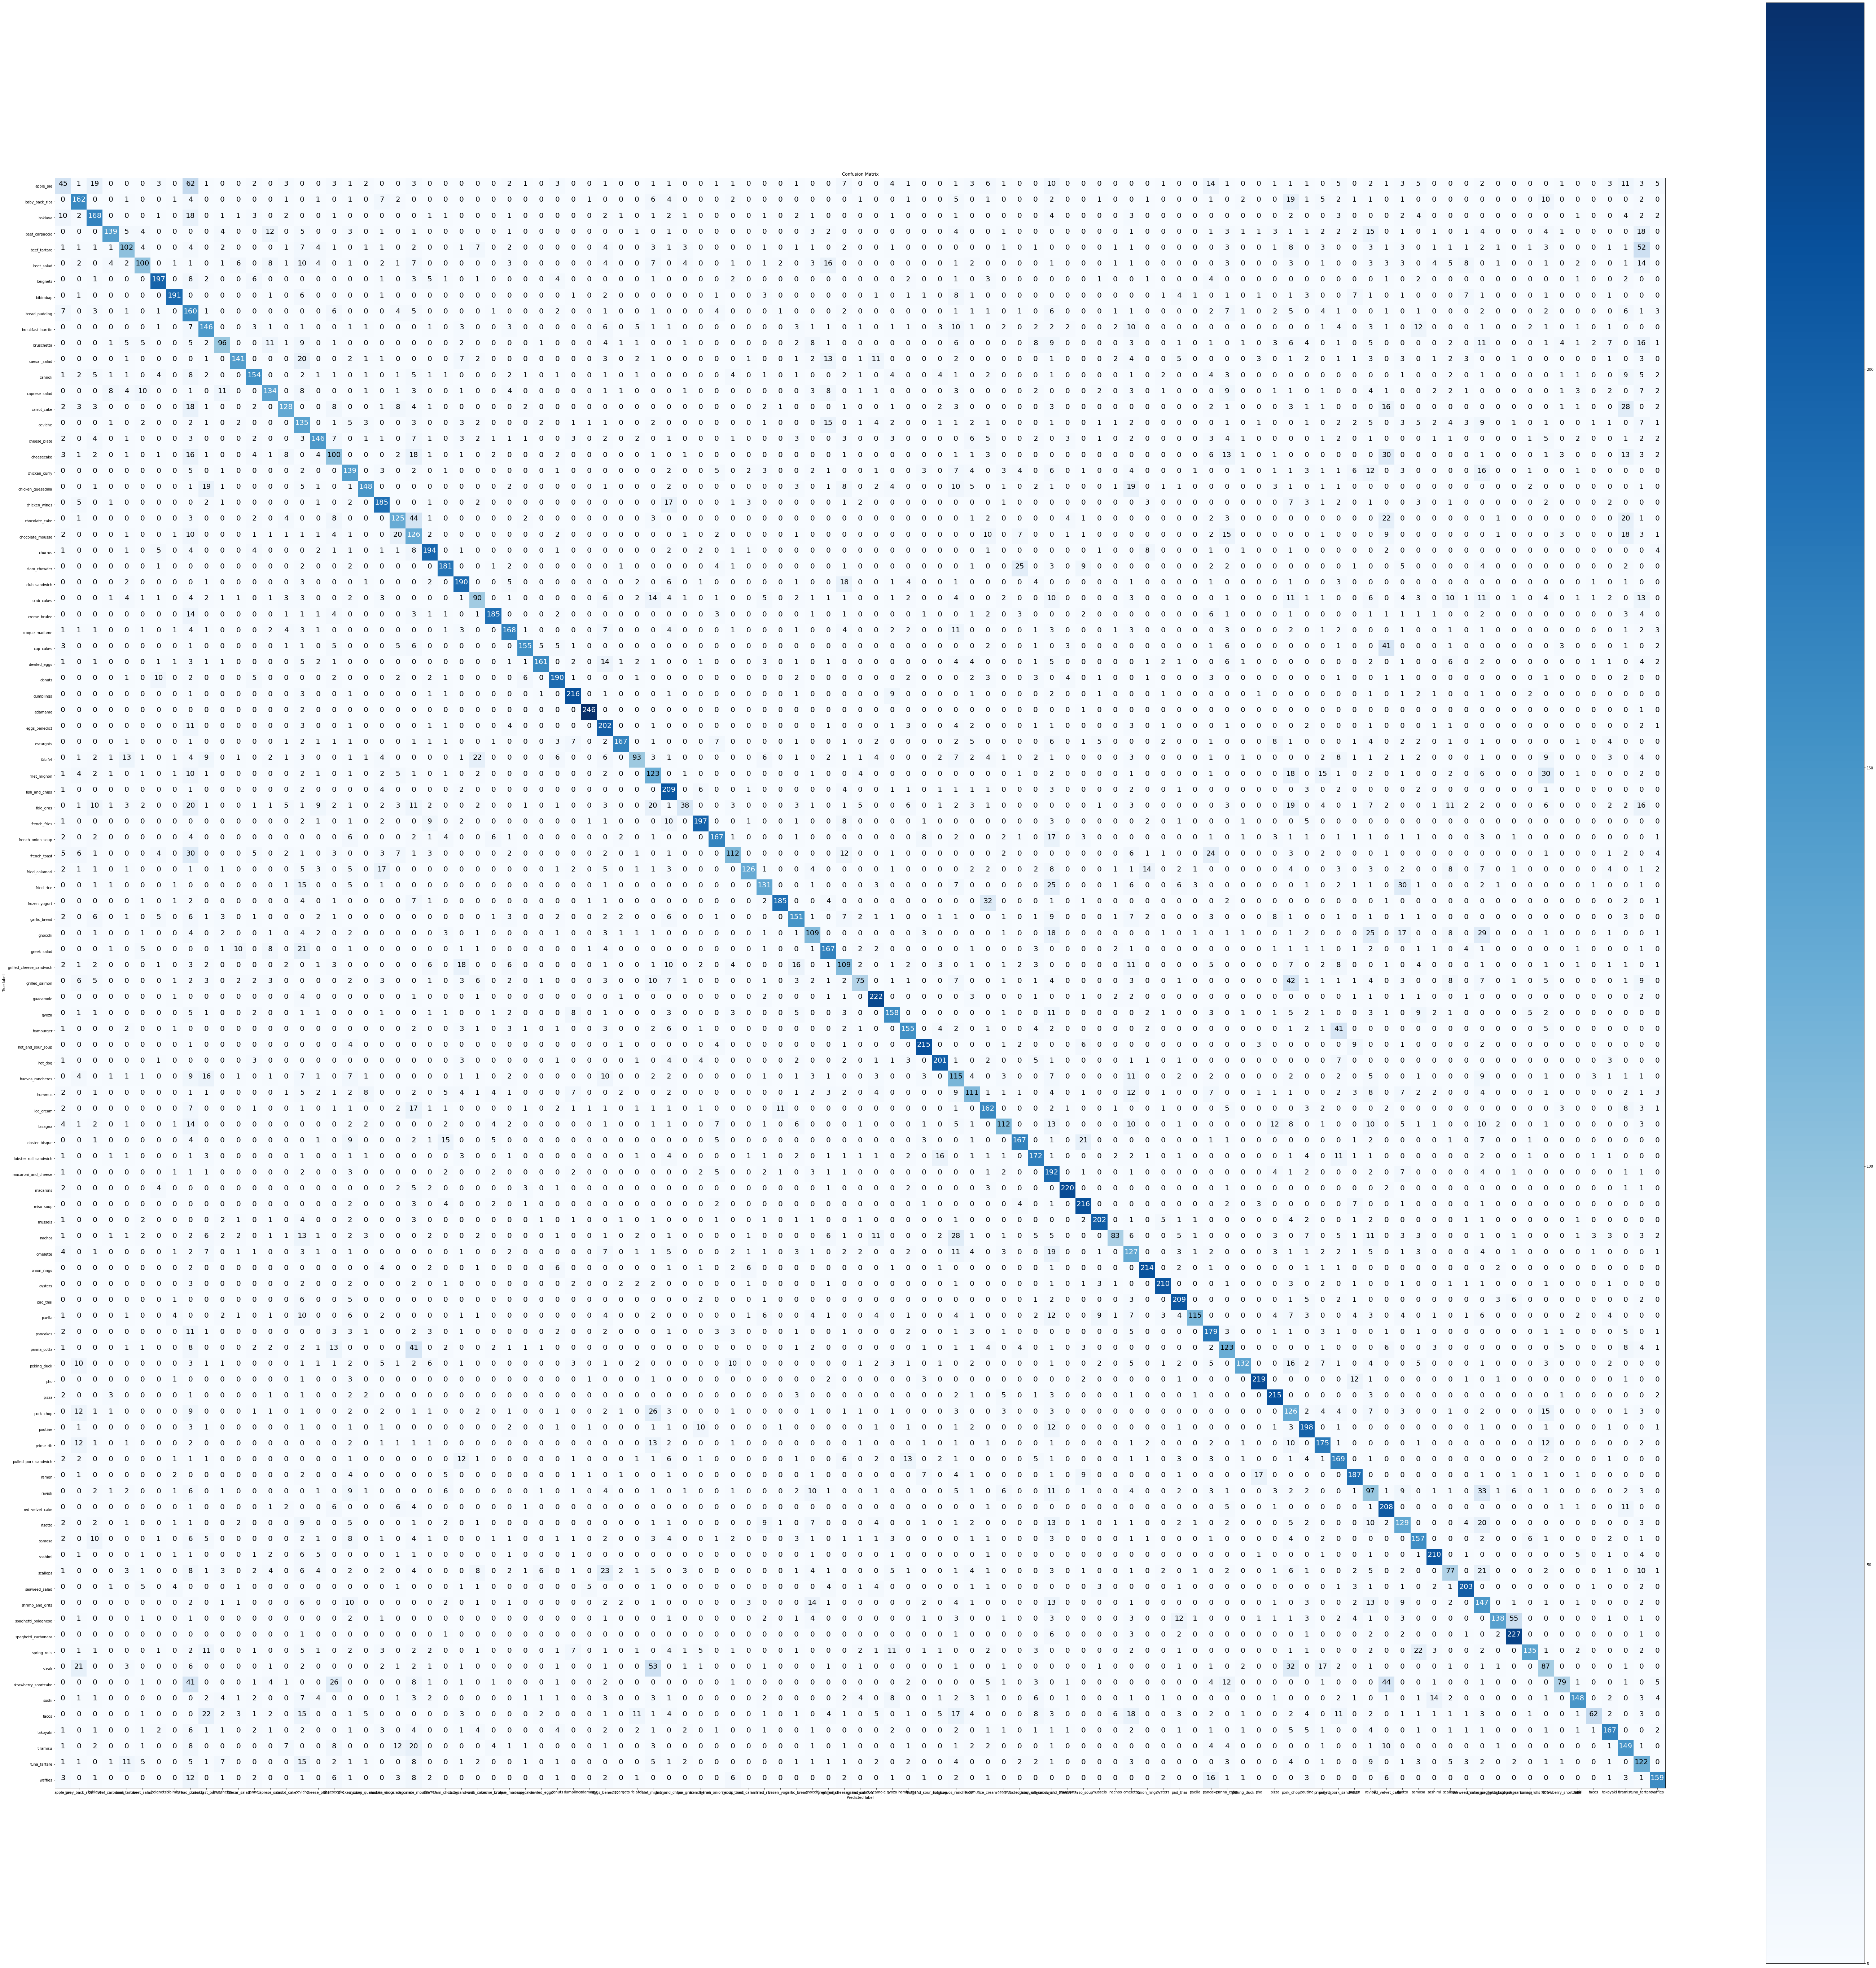

In [57]:
from helper_functions import make_confusion_matrix

make_confusion_matrix(y_true=y_labels,
                     y_pred=pred_classes,
                     classes=class_names,
                     figsize=(100,100),
                     text_size=20)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall, and F1) called classfication report

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_labels,y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.34      0.18      0.23       250
           1       0.60      0.65      0.62       250
           2       0.62      0.67      0.65       250
           3       0.81      0.56      0.66       250
           4       0.56      0.41      0.47       250
           5       0.62      0.40      0.49       250
           6       0.80      0.79      0.80       250
           7       0.86      0.76      0.81       250
           8       0.24      0.64      0.35       250
           9       0.52      0.58      0.55       250
          10       0.62      0.38      0.48       250
          11       0.79      0.56      0.66       250
          12       0.70      0.62      0.66       250
          13       0.64      0.54      0.58       250
          14       0.70      0.51      0.59       250
          15       0.30      0.54      0.39       250
          16       0.68      0.58      0.63       250
          17       0.43    

The numbers above give a great class-by-class evaultaion of our model's predictions but with so many classes, they're quite hard to understand.


How about we create a visualization to get a better understanding?

In [61]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels,pred_classes,output_dict=True)
classification_report_dict

{'0': {'precision': 0.3358208955223881,
  'recall': 0.18,
  'f1-score': 0.234375,
  'support': 250},
 '1': {'precision': 0.5955882352941176,
  'recall': 0.648,
  'f1-score': 0.6206896551724138,
  'support': 250},
 '2': {'precision': 0.6222222222222222,
  'recall': 0.672,
  'f1-score': 0.6461538461538461,
  'support': 250},
 '3': {'precision': 0.8081395348837209,
  'recall': 0.556,
  'f1-score': 0.6587677725118484,
  'support': 250},
 '4': {'precision': 0.56353591160221,
  'recall': 0.408,
  'f1-score': 0.4733178654292343,
  'support': 250},
 '5': {'precision': 0.6211180124223602,
  'recall': 0.4,
  'f1-score': 0.48661800486618007,
  'support': 250},
 '6': {'precision': 0.8040816326530612,
  'recall': 0.788,
  'f1-score': 0.795959595959596,
  'support': 250},
 '7': {'precision': 0.8603603603603603,
  'recall': 0.764,
  'f1-score': 0.809322033898305,
  'support': 250},
 '8': {'precision': 0.24096385542168675,
  'recall': 0.64,
  'f1-score': 0.35010940919037203,
  'support': 250},
 '9': {

Let's plot all of our classes F1 scores ...

In [63]:
class_names[98]

'tiramisu'

In [65]:
classification_report_dict["99"]["f1-score"]

0.38425196850393695

In [69]:
# Create empty dictionary
class_f1_scores = {}

# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
    if k == "accuracy": # stop once we get to accuracy key
        break
    else:
        # Add class names and f1-scores to new dictionary
        class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.234375,
 'baby_back_ribs': 0.6206896551724138,
 'baklava': 0.6461538461538461,
 'beef_carpaccio': 0.6587677725118484,
 'beef_tartare': 0.4733178654292343,
 'beet_salad': 0.48661800486618007,
 'beignets': 0.795959595959596,
 'bibimbap': 0.809322033898305,
 'bread_pudding': 0.35010940919037203,
 'breakfast_burrito': 0.5478424015009381,
 'bruschetta': 0.4752475247524752,
 'caesar_salad': 0.6588785046728972,
 'cannoli': 0.6567164179104478,
 'caprese_salad': 0.5826086956521739,
 'carrot_cake': 0.5912240184757507,
 'ceviche': 0.38737446197991393,
 'cheese_plate': 0.6293103448275862,
 'cheesecake': 0.4149377593360996,
 'chicken_curry': 0.5045372050816698,
 'chicken_quesadilla': 0.6788990825688073,
 'chicken_wings': 0.7061068702290076,
 'chocolate_cake': 0.5341880341880342,
 'chocolate_mousse': 0.37278106508875736,
 'churros': 0.7475915221579961,
 'clam_chowder': 0.7269076305220884,
 'club_sandwich': 0.7156308851224105,
 'crab_cakes': 0.42857142857142855,
 'creme_brulee': 0.780

In [70]:
# Turn f1-scores into dataframe for visualization
import pandas as pd

f1_scores=pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                        "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [71]:
f1_scores[:10]

,class_names,f1-score
33,edamame,0.964706
63,macarons,0.896130
75,pho,0.872510
69,oysters,0.855397
54,hot_and_sour_soup,0.846457
68,onion_rings,0.842520
65,mussels,0.831276
32,dumplings,0.829175
86,sashimi,0.826772
45,frozen_yogurt,0.816777


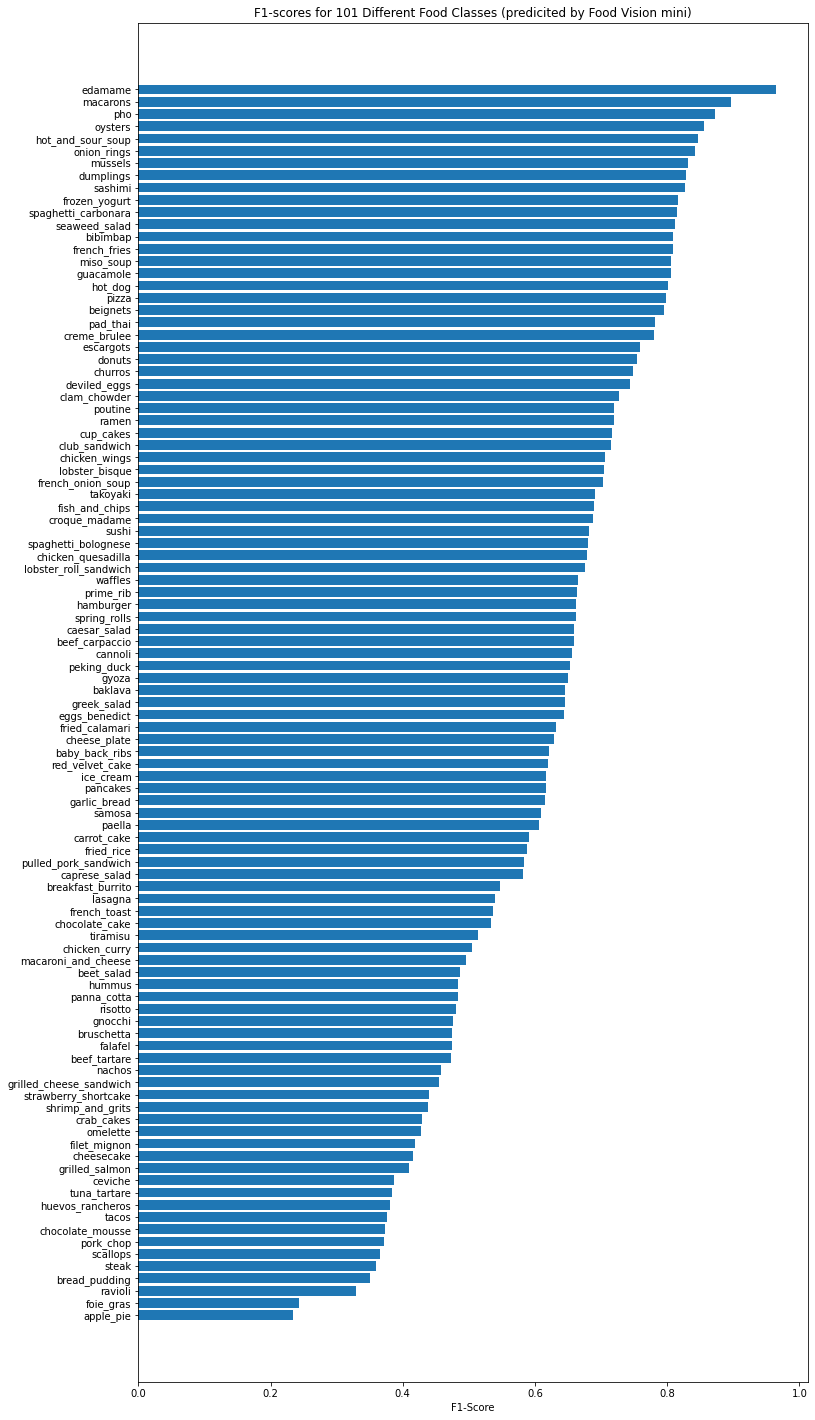

In [79]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"]);
ax.set_xlabel("F1-Score")
ax.set_title("F1-scores for 101 Different Food Classes (predicited by Food Vision mini)");
ax.invert_yaxis();

## Visualizing predictions on test images

Now, this is the real test. How does our model perform on food images not even in our test dataset (images of our own, we'll see this later on).

To visualize our model's predicitons on our own images, we'll need a function to load and preporcess images, specifically it will need to:
* Read in a target image filepath `tf.io.read_file()`
* Turn the image into a Tensor using `tf.io.decode_image()`
* Resize the image tensor to be the same size as the images our model has trained on using `tf.image.resize()`
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)



In [97]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img


Now we have a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability, and truth label

101_food_classes_10_percent/test/garlic_bread/3210415.jpg
1/1 [==============================] - 0s 28ms/step
101_food_classes_10_percent/test/chocolate_mousse/106928.jpg
1/1 [==============================] - 0s 27ms/step
101_food_classes_10_percent/test/ceviche/157273.jpg
1/1 [==============================] - 0s 24ms/step


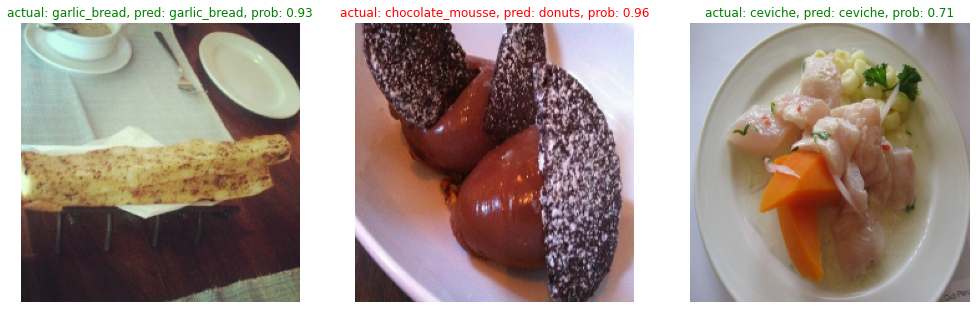

In [115]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
    # Choose random image from a random classes
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir+class_name+"/"+filename
    print(filepath)

    # Load the image and make predictions
    img = load_and_prep_image(filepath,scale=False)
    pred_prob = model.predict(tf.expand_dims(img,axis=0)) # get predicition probability array
    pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index

    # Plot the images(s)
    plt.subplot(1,3,i+1)
    plt.imshow(img/255.)

    if class_name == pred_class: # if predicted class matches truth class, make text green
        title_color = "g"
    else:
        title_color = "r"

    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);